<font size = 6> Credit Card Customer Churn (unsupervised)<font> <br>

<font size = 5> **About Data** <font>

In this project we will be classifying credit card customer data for churn behavior using Kmeans Clustering on the data below:


A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

Here is the link to the dataset in Kaggle:

https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

Now, this dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.

<font size = 5> **Load Packages** <font>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

<font size = 5> **Read Data** <font>

In [2]:
df = pd.read_csv("BankChurners.csv")

#data size
print(df.shape)

df.head()

(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
#feature types
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

first column is client id and two last columns are for naive bayes model so we can eliminate them.

In [4]:
#remove 1st, and two last columns
df.drop(df.columns[[0, 21, 22]], axis = 1, inplace = True)

In [5]:
df.select_dtypes(["object"])

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue
3,Existing Customer,F,High School,Unknown,Less than $40K,Blue
4,Existing Customer,M,Uneducated,Married,$60K - $80K,Blue
...,...,...,...,...,...,...
10122,Existing Customer,M,Graduate,Single,$40K - $60K,Blue
10123,Attrited Customer,M,Unknown,Divorced,$40K - $60K,Blue
10124,Attrited Customer,F,High School,Married,Less than $40K,Blue
10125,Attrited Customer,M,Graduate,Unknown,$40K - $60K,Blue


In [97]:
#define a function to show the unique values of a column
def unique_values(df):
    dict = {}
    categorical_cols = df.select_dtypes(["object"]).columns
    for col in categorical_cols:
        dict[col] = df[col].unique()
    return dict


unique_values(df)

{'Gender': array(['M', 'F'], dtype=object),
 'Education_Level': array(['High School', 'Graduate', 'Uneducated', 'College',
        'Post-Graduate', 'Doctorate'], dtype=object),
 'Marital_Status': array(['Married', 'Single', 'Divorced'], dtype=object),
 'Income_Category': array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
        '$120K +'], dtype=object),
 'Card_Category': array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)}

**Note:** <br>
We see that there are some unknown categories for columns Education_Level, Martial_Status and Income_Category. Let's check them out.

In [7]:
print(df[df["Income_Category"] == "Unknown"].shape[0])
print(df[df["Marital_Status"] == "Unknown"].shape[0])
print(df[df["Education_Level"] == "Unknown"].shape[0])

1112
749
1519


In [96]:
#define a function to replace unknown values with the majority category of each column
def missing_value_filler(column):
    majority_category = column.mode()[0]
    column = column.replace("Unknown", majority_category)
    return column

#Apply function on the columns with missing values
missing_columns = ["Income_Category", "Marital_Status", "Education_Level"]
df[missing_columns] = df[missing_columns].apply(missing_value_filler, axis = 0)

#change name of target column 
df.rename(columns = {"Attrition_Flag": "churn"}, inplace = True)
df["churn"] = df["churn"].map({'Existing Customer': 0, 'Attrited Customer': 1})

<font size = 5> **Any null values?** <font>

In [98]:
df.isnull().sum()

churn                       0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

<font size = 5> **Data Visualization** <font>

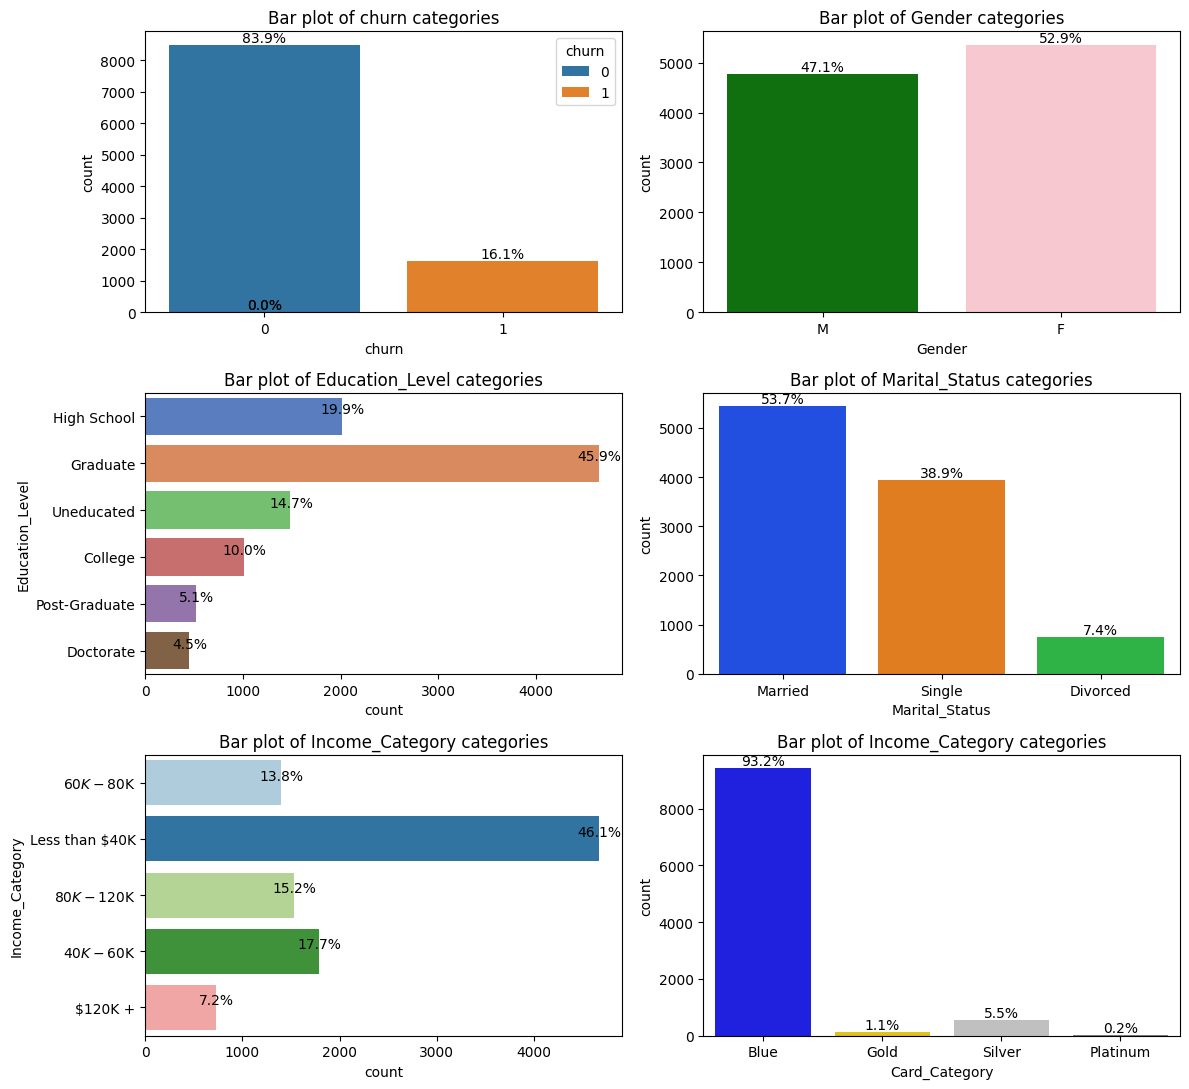

In [100]:
fig, axes = plt.subplots(3, 2, figsize = (12, 11))


##Attrition_Flag Plot
sns.countplot(x = "churn", data = df, 
              hue = "churn",
              ax = axes[0, 0])
axes[0, 0].set_title("Bar plot of churn categories")

counts = df['churn'].value_counts()
total = len(df)
percentages = counts / total * 100

# Add percentage labels to each bar
for p in axes[0, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[0, 0].text(x, y, percentage, ha='center', va='bottom')


##Gender Plot
sns.countplot(x = "Gender", data = df,
              hue = "Gender", palette = ["green", "pink"],
              ax = axes[0, 1])
axes[0, 1].set_title("Bar plot of Gender categories")


counts = df['Gender'].value_counts()
total = len(df)
percentages = counts / total * 100

# Add percentage labels to each bar
for p in axes[0, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[0, 1].text(x, y, percentage, ha='center', va='bottom')


##Education_Level Plot
sns.countplot(y = "Education_Level", data = df,
              hue = "Education_Level", palette = "muted",
              ax = axes[1, 0])
axes[1, 0].set_title("Bar plot of Education_Level categories")
\
counts = df['Education_Level'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[1, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = width
    y = p.get_y() + height / 2
    percentage = f'{width / total * 100:.1f}%'
    axes[1, 0].text(x + 5, y, percentage, ha='center', va='bottom')


##Marital_Status Plot
sns.countplot(x = "Marital_Status", data = df,
              hue = "Marital_Status", palette = "bright",
              ax = axes[1, 1])
axes[1, 1].set_title("Bar plot of Marital_Status categories")

counts = df['Marital_Status'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[1, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[1, 1].text(x , y, percentage, ha='center', va='bottom')

##Income_Category Plot
sns.countplot(y = "Income_Category", data = df,
              hue = "Income_Category", palette = "Paired",
              ax = axes[2, 0])
axes[2, 0].set_title("Bar plot of Income_Category categories")

counts = df['Income_Category'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[2, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = width
    y = p.get_y() + height / 2
    percentage = f'{width / total * 100:.1f}%'
    axes[2, 0].text(x + 5 , y, percentage, ha='center', va='bottom')



##Card_Category Plot
sns.countplot(x = "Card_Category", data = df,
              hue = "Card_Category", palette = ["blue", "gold", "silver", "grey"],
              ax = axes[2, 1])
axes[2, 1].set_title("Bar plot of Income_Category categories")

counts = df['Income_Category'].value_counts()
total = len(df)
percentage = counts / total * 100

# Add percentage labels to each bar
for p in axes[2, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[2, 1].text(x , y, percentage, ha='center', va='bottom')

plt.tight_layout()


**Note:** <br>
Observations based on the plots: <br>
The credit card customers are mostly graduates, existing customer, married, with less than 40K$ annual salary and blue card holders. <br>
The target variable (churn) is imbalanced, with only 16% of cases resulting in churn.

Text(0.5, 1.0, 'Box plot of Credit_Limit based on Gender')

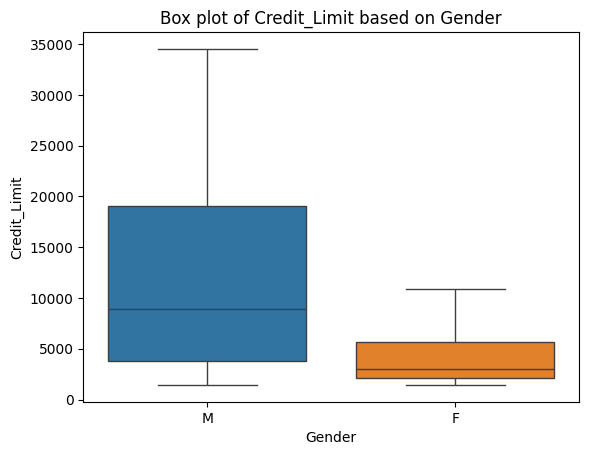

In [56]:
sns.boxplot(x = "Gender", y = "Credit_Limit",data = df,
           hue = "Gender", showfliers = False)
plt.title("Box plot of Credit_Limit based on Gender")

**Note:** <br>
Although the number of female credit card holders is higher, their average credit limit, as well as their 1st and 3rd quartile limits, are lower compared to males.

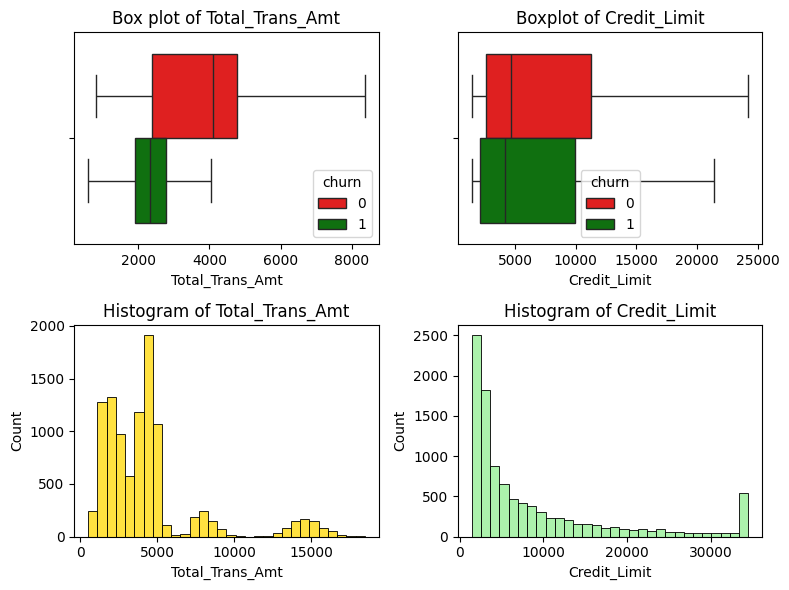

In [118]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

#distribution of Total_Trans_Amt
sns.boxplot(x = "Total_Trans_Amt", data = df, 
            hue = "churn", palette = ["red", "green"],
            showfliers = False,
            ax = axes[0, 0])
axes[0, 0].set_title("Box plot of Total_Trans_Amt")

sns.histplot(df["Total_Trans_Amt"], 
             bins = 30, color = "gold",
             ax = axes[1, 0])
axes[1, 0].set_title("Histogram of Total_Trans_Amt")

#distribution of
sns.boxplot(x = "Credit_Limit", data = df,
            hue = "churn", palette = ["red", "green"], 
            showfliers = False, 
            ax = axes[0, 1])
axes[0, 1].set_title("Boxplot of Credit_Limit")

sns.histplot(x = df["Credit_Limit"],
             bins = 30, color = "lightgreen",
             ax = axes[1, 1])
axes[1, 1].set_title("Histogram of Credit_Limit")
plt.tight_layout()

The total transaction amount has a multimodal distribution, which can help us identify different customer clusters. On the other hand, the credit limit is right-skewed and has a sudden spike at the high end, which is pretty interesting. Churn and non-churn creditcard holders have distinct distribution of Total_Trans_Amt, however their Credit_Limit transaction look similar.

In [ ]:
fig, axes

In [79]:
fig, axes = plt.subplots(4, 2, figsize = (10, 12))

sns.boxplot

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Married,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Graduate,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Married,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [13]:
data = list(zip(x, y))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

TypeError: 'numpy.float64' object is not iterable

In [14]:
KMeans_model = KMeans(n_clusters = 2, random_state = 0)
KMeans_model.fit(df)

ValueError: could not convert string to float: 'Existing Customer'

**Note:** <br>
Kmeans clustering would not give us very accurate result if we include the categorical columns as dummy variables. This algorithm is based on measuring the distance of the data points from each other and best result would occur if we only use the numerical variables. <br>
We would use Kmeans clustering only on numerical data and after that we will use XGBoost using all the variables and compare the predicitons.

In [28]:
numerical_df = df.select_dtypes(exclude = ["object"])
numerical_df

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,50,2,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,41,2,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,44,1,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,30,2,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
